# Autoencoders

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
import os

from skimage.util import random_noise
from keras.models import Model
from keras.layers import Input, Dense
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from keras.layers import Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter



In [71]:

def apply_salt_and_pepper(image, salt_ratio, pepper_ratio):
    """
    Aplica el filtro "Salt and Pepper" a una imagen.
    
    Args:
        image: Imagen de entrada.
        salt_ratio: porcentaje de puntos blancos
        pepper_ratio: porcentaje de puntos negros
        
    Returns:
        Imagen con el filtro "Salt and Pepper" aplicado.
    """
    
    row, col, _= image.shape
    salt = np.random.rand(row, col) < salt_ratio
    pepper = np.random.rand(row, col) < pepper_ratio
    noisy_image = image
    noisy_image[salt] = [255,255,255]
    noisy_image[pepper] = [0,0,0]
    return noisy_image

def apply_salt_and_pepper_to_images(input_dir, output_dir, pepper_ratio=0.03, salt_ratio=0.03):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for root, _, files in os.walk(input_dir):
        print(root)
        for filename in files:
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_dir, os.path.relpath(input_path, input_dir))

                # Leer la imagen
            image = cv2.imread(input_path)

                # Convertir la imagen a escala de grises

                # Aplicar el filtro "Salt and Pepper"
            noisy_image = apply_salt_and_pepper(image, salt_ratio, pepper_ratio)

                # Crear la estructura de carpetas en el directorio de salida
            output_folder = os.path.dirname(output_path)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

                # Guardar la imagen con el filtro aplicado
            cv2.imwrite(output_path, noisy_image)


# Ejemplo de uso
input_directory = "G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset"
output_directory = "G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/noise_dataset"

apply_salt_and_pepper_to_images(input_directory, output_directory)

G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Apple_scab
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Black_rot
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Cedar_apple_rust
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Blueberry___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Cherry___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Cherry___Powdery_mildew
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___Cercospora_leaf_spot Gray_leaf_spot
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___Common_rust
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_

In [2]:
parent_folder_path = "Imagenes/resized_dataset/"

categories = {}

# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [3]:


"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.8, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


X_auto_noise = np.zeros_like(X_auto)
for i in range(X_auto.shape[0]):
    X_auto_noise[i] = random_noise(X_auto[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

X_train_noise = np.zeros_like(X_train)
for i in range(X_train.shape[0]):
    X_train_noise[i] = random_noise(X_train[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

    




In [86]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""
arrays_labels = np.array(arrays_labels)

X_noise_auto, X_noise, y__noise_auto, y_noise = train_test_split(noise_arrays, arrays_labels, test_size=0.8, random_state=42, stratify=arrays_labels)

X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, y_noise, test_size=0.5, random_state=42, stratify=y)


# normalize 
X_noise_auto = np.array(X_noise_auto).astype('float32') / 255
X_train_noise = np.array(X_train_noise).astype('float32') / 255
X_test_noise = np.array(X_test_noise).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_noise_auto = X_noise_auto.reshape((len(X_noise_auto), 64, 64, 3))
X_train_noise = X_train_noise.reshape((len(X_train_noise), 64, 64, 3))
X_test_noise = X_test_noise.reshape((len(X_test_noise), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train_noise = to_categorical(y_train, num_classes=38)
y_test_noise = to_categorical(y_test, num_classes=38)
y_noise = to_categorical(y, num_classes=38)

In [4]:
input_img = Input(shape=X_auto_noise[0].shape)
# Encoder
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
encoded = MaxPooling2D((2, 2), padding="same")(encoded)
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
latent = MaxPooling2D((2, 2), padding="same")(encoded)

# Decoder
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(latent)
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(decoded)

autoencoder = Model(input_img, decoded)

In [5]:

optimizer = Adam(learning_rate = 0.019417802984540277)
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(x = X_auto_noise, y = X_auto,
                epochs=8,
                batch_size=256,
                shuffle=True,    
                verbose=1)

Epoch 1/8
27/27 [==============================] - 12s 403ms/step - loss: 0.0270 - accuracy: 0.8543
Epoch 2/8
27/27 [==============================] - 11s 409ms/step - loss: 0.0184 - accuracy: 0.8771
Epoch 3/8
27/27 [==============================] - 11s 400ms/step - loss: 0.0107 - accuracy: 0.8771
Epoch 4/8
27/27 [==============================] - 11s 403ms/step - loss: 0.0090 - accuracy: 0.8771
Epoch 5/8
27/27 [==============================] - 11s 404ms/step - loss: 0.0082 - accuracy: 0.8771
Epoch 6/8
27/27 [==============================] - 11s 402ms/step - loss: 0.0076 - accuracy: 0.8769
Epoch 7/8
27/27 [==============================] - 11s 389ms/step - loss: 0.0066 - accuracy: 0.8771
Epoch 8/8
27/27 [==============================] - 11s 408ms/step - loss: 0.0056 - accuracy: 0.8770


1/1 [==============================] - 0s 42ms/step


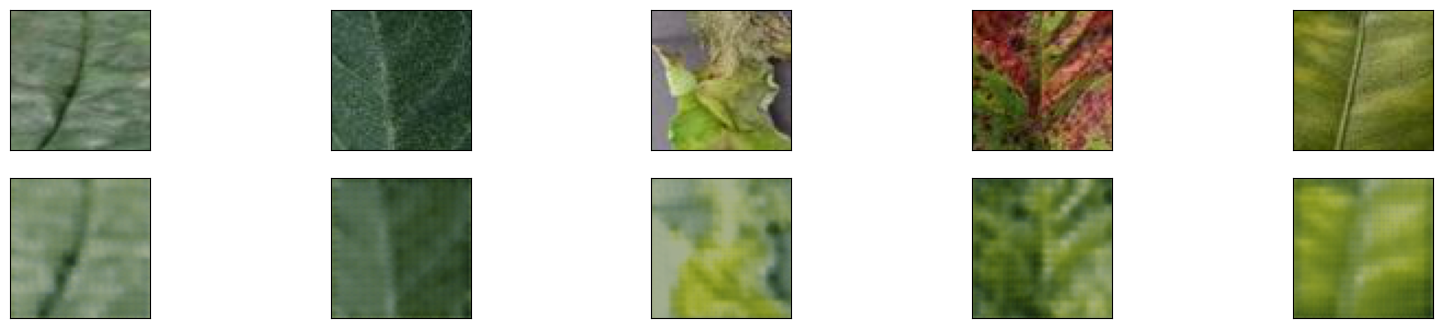

In [48]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
encoded_no_labels = encoder.predict(X_auto)

216/216 [==============================] - 1s 7ms/step


In [13]:
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=encoded_train[0].shape)
output = Flatten()(input_latent)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = 0.0005)
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=100,
               batch_size=128,
               verbose=1,
               validation_data=(encoded_test, y_test))



Epoch 1/100
108/108 [==============================] - 6s 44ms/step - loss: 0.0484 - accuracy: 0.0313 - val_loss: 0.0263 - val_accuracy: 0.0261
Epoch 2/100
108/108 [==============================] - 4s 41ms/step - loss: 0.0261 - accuracy: 0.0458 - val_loss: 0.0259 - val_accuracy: 0.0527
Epoch 3/100
108/108 [==============================] - 4s 40ms/step - loss: 0.0258 - accuracy: 0.0688 - val_loss: 0.0256 - val_accuracy: 0.0776
Epoch 4/100
108/108 [==============================] - 5s 42ms/step - loss: 0.0256 - accuracy: 0.0819 - val_loss: 0.0255 - val_accuracy: 0.0760
Epoch 5/100
108/108 [==============================] - 4s 40ms/step - loss: 0.0254 - accuracy: 0.0883 - val_loss: 0.0253 - val_accuracy: 0.0947
Epoch 6/100
108/108 [==============================] - 5s 42ms/step - loss: 0.0252 - accuracy: 0.1005 - val_loss: 0.0252 - val_accuracy: 0.1078
Epoch 7/100
108/108 [==============================] - 4s 40ms/step - loss: 0.0251 - accuracy: 0.1125 - val_loss: 0.0251 - val_accuracy:

In [14]:
predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

432/432 [==============================] - 13s 30ms/step


In [16]:


# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])
for i in range(len(real_values)):
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

Accuracy:  0.32436938242968977
Precision:  [0.11111111 0.27906977 0.         0.48208469 0.18527316 0.24210526
 0.19427037 0.         0.40572391 0.21073826 0.63373494 0.20356234
 0.28748068 0.41428571 0.11111111 0.55919854 0.38901099 0.4
 0.34013605 0.25742574 0.33760684 0.12146893 0.65702479 0.31034483
 0.38653367 0.27855711 0.30206677 0.11764706 0.38737446 0.12121212
 0.33625731 0.28099174 0.1835206  0.31923077 0.27133479 0.48319328
 0.13636364 0.29387755]
Recall:  [0.00793651 0.19354839 0.         0.33636364 0.17727273 0.10926366
 0.63450292 0.         0.54772727 0.39847716 0.59772727 0.18181818
 0.42272727 0.47209302 0.01183432 0.69772727 0.40227273 0.41666667
 0.12531328 0.05909091 0.395      0.1075     0.6091954  0.06040268
 0.70454545 0.31590909 0.43181818 0.01098901 0.61363636 0.12
 0.26136364 0.26771654 0.11136364 0.18863636 0.28181818 0.52272727
 0.06040268 0.32727273]
F1 score:  [0.01481481 0.22857143 0.         0.39625167 0.18118467 0.15057283
 0.29746402 0.         0.466150

c:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


General AUC: 0.6530545477341652


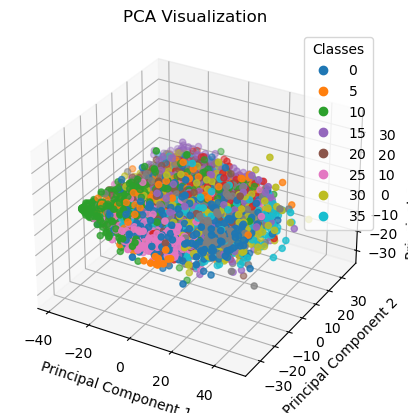

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_no_labels.reshape(6898,4096))

# Aplicar PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Guardar los resultados de PCA en TensorBoard
writer = SummaryWriter()
writer.add_embedding(X_pca, metadata=y_auto)
writer.close()
    
# Visualizar los resultados de PCA en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_auto, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.set_title('PCA Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()